<a href="https://colab.research.google.com/github/Rajeeb321123/Pytorch/blob/master/06_%26_07_Workout_Exercises_Video_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kaggle
!pip install av
!pip install -q "tqdm>=4.64.1"
!pip install mermaid-py
!pip install torchinfo
!pip install psutil

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


'cuda'

In [2]:
# Are we using a GPU?
!nvidia-smi

Wed Feb 26 04:36:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data

In [4]:
import os

# Set Kaggle API credentials
os.environ["KAGGLE_USERNAME"] = "rajeepthapa"
os.environ["KAGGLE_KEY"] = "55ba83ad31890ca94883d150a3f68903"

In [5]:
!kaggle datasets download -d hasyimabdillah/workoutfitness-video
# !kaggle datasets download -d trainingdatapro/real-vs-fake-anti-spoofing-video-classification

Dataset URL: https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video
License(s): CC-BY-NC-SA-4.0
100% 4.32G/4.32G [03:19<00:00, 23.7MB/s]
100% 4.32G/4.32G [03:19<00:00, 23.3MB/s]


In [6]:
import zipfile
import os

# Path to the zip file
zip_file_path = "/content/workoutfitness-video.zip"

# Path to the extraction directory
extract_dir = "/content/workoutfitness"

# Create the extraction directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file into the specified directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to {extract_dir}")

Extracted files to /content/workoutfitness


In [7]:
import os
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/workoutfitness"):
  print(f"There are {len(dirnames)} directoreis and {len(filenames)} videos in'{dirpath}'.")

There are 22 directoreis and 0 videos in'/content/workoutfitness'.
There are 0 directoreis and 7 videos in'/content/workoutfitness/plank'.
There are 0 directoreis and 12 videos in'/content/workoutfitness/decline bench press'.
There are 0 directoreis and 26 videos in'/content/workoutfitness/pull Up'.
There are 0 directoreis and 14 videos in'/content/workoutfitness/romanian deadlift'.
There are 0 directoreis and 21 videos in'/content/workoutfitness/t bar row'.
There are 0 directoreis and 32 videos in'/content/workoutfitness/deadlift'.
There are 0 directoreis and 17 videos in'/content/workoutfitness/shoulder press'.
There are 0 directoreis and 19 videos in'/content/workoutfitness/hammer curl'.
There are 0 directoreis and 61 videos in'/content/workoutfitness/bench press'.
There are 0 directoreis and 51 videos in'/content/workoutfitness/lat pulldown'.
There are 0 directoreis and 13 videos in'/content/workoutfitness/russian twist'.
There are 0 directoreis and 50 videos in'/content/workoutfit

In [8]:
import os

video_counts = {}

# Define valid video file extensions
video_extensions = ('.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv')

# Walk through the directory and count video files in each subdirectory
base_dir = "/content/workoutfitness"

for dirpath, dirnames, filenames in os.walk(base_dir):
    video_files = [f for f in filenames if f.lower().endswith(video_extensions)]
    video_counts[dirpath] = len(video_files)

# Sort directories by number of videos in descending order
top_two = sorted(video_counts.items(), key=lambda x: x[1], reverse=True)[:2]

# Print the top three subdirectories with the most videos
for path, count in top_two:
    print(f"Directory: {path}, Video Count: {count}")

top_two_path = [subdir for subdir, _ in top_two]
print(top_two_path)

Directory: /content/workoutfitness/barbell biceps curl, Video Count: 62
Directory: /content/workoutfitness/bench press, Video Count: 61
['/content/workoutfitness/barbell biceps curl', '/content/workoutfitness/bench press']


In [ ]:
# import shutil

# # Define the path of the folder you want to delete
# folder_path = "/content/real-vs-fake-anti-spoofing-video-classification_50"

# # Delete the folder and its contents
# shutil.rmtree(folder_path)

# print(f"Folder '{folder_path}' has been deleted.")


Folder '/content/real-vs-fake-anti-spoofing-video-classification_50%' has been deleted.


In [9]:
import os
import shutil
import random

source_folder = "/content/workoutfitness"  # Main dataset folder
train_folder = "/content/workoutfitness_100%/split_data/train"  # Train dataset (20%)
test_folder = "/content/workoutfitness_100%/split_data/test"    # Test dataset (5%)

# Create train and test directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# /content/workoutfitness/barbell biceps curl/barbell biceps curl_1.mp4


for subdir in os.listdir(source_folder):
    subdir_path = os.path.join(source_folder, subdir)

    if subdir_path not in top_two_path:
        continue

    if os.path.isdir(subdir_path):  # Ensure it's a directory
        videos = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path)
                  if f.lower().endswith(('.mp4', '.avi', '.mkv', '.webm', 'flv'))]

        # Shuffle images for randomness
        random.shuffle(videos)

        # Compute split sizes
        total_images = len(videos)
        train_size = max(1, int(0.75 * total_images))  # 75% for training
        test_size = max(1, int(0.25 * total_images))  # 25% for testing

        # Select images for train and test
        train_videos = videos[:train_size]
        test_videos = videos[train_size:train_size + test_size]

        # Create subdirectories in train and test folders
        train_subdir = os.path.join(train_folder, subdir)
        test_subdir = os.path.join(test_folder, subdir)

        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Copy images to respective folders
        for img in train_videos:
            shutil.copy(img, os.path.join(train_subdir, os.path.basename(img)))

        for img in test_videos:
            shutil.copy(img, os.path.join(test_subdir, os.path.basename(img)))

        print(f"Processed '{subdir}': {len(train_videos)} train, {len(test_videos)} test")


def count_videos(folder):
    count = 0
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            count += len(os.listdir(subdir_path))
    return count

print(f"Total Train videos: {count_videos(train_folder)}")
print(f"Total Test videos: {count_videos(test_folder)}")

Processed 'bench press': 45 train, 15 test
Processed 'barbell biceps curl': 46 train, 15 test
Total Train videos: 91
Total Test videos: 30


In [ ]:
# import os
# import shutil
# import random

# # Define source and destination root directories
# source_root = '/content/real-vs-fake-anti-spoofing-video-classification'          # Replace with your videos folder path
# destination_root = '/content/real-vs-fake-anti-spoofing-video-classification_50%'  # Replace with your desired output folder path

# # Define the subdirectories based on your structure
# categories = ['train', 'test']
# labels = ['attack', 'real_video']

# for category in categories:
#     for label in labels:
#         # Build the full source and destination paths for each subfolder
#         source_dir = os.path.join(source_root, category, label)
#         dest_dir = os.path.join(destination_root, category, label)

#         # Create destination folder if it doesn't exist
#         os.makedirs(dest_dir, exist_ok=True)

#         # Get list of video files in the source folder
#         # Optionally, filter files by extension if needed (e.g., .mp4, .avi)
#         video_files = [f for f in os.listdir(source_dir)
#                        if os.path.isfile(os.path.join(source_dir, f))]

#         # Determine number of files to sample (50% of the videos)
#         num_to_copy = len(video_files) // 2

#         # Randomly sample the files
#         selected_files = random.sample(video_files, num_to_copy)

#         # Copy each selected file to the destination folder
#         for video in selected_files:
#             src_file = os.path.join(source_dir, video)
#             dest_file = os.path.join(dest_dir, video)
#             shutil.copy(src_file, dest_file)
#             print(f"Copied {src_file} to {dest_file}")


Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/11.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/11.mp4
Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/42.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/42.mp4
Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/0.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/0.mp4
Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/8.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/8.mp4
Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/47.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/47.mp4
Copied /content/real-vs-fake-anti-spoofing-video-classification/train/attack/21.mp4 to /content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack/21.

In [ ]:
# import os
# # Walk through pizza_steak directory and list number of files
# for dirpath, dirnames, filenames in os.walk("/content/real-vs-fake-anti-spoofing-video-classification_50%"):
#   print(f"There are {len(dirnames)} directoreis and {len(filenames)} videos in'{dirpath}'.")

There are 2 directoreis and 0 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%'.
There are 2 directoreis and 0 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/test'.
There are 0 directoreis and 12 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/test/real_video'.
There are 0 directoreis and 12 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/test/attack'.
There are 2 directoreis and 0 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/train'.
There are 0 directoreis and 27 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/train/real_video'.
There are 0 directoreis and 27 videos in'/content/real-vs-fake-anti-spoofing-video-classification_50%/train/attack'.


In [3]:
train_dir = "/content/workoutfitness_100%/split_data/train"
test_dir = "/content/workoutfitness_100%/split_data/test"

In [4]:
# Let's get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['barbell biceps curl' 'bench press']


In [ ]:
import os
import random
import cv2 # You still need this for video reading
from IPython.display import HTML, display
from base64 import b64encode

# Function to select and view a random video from a target directory
def view_random_video(target_dir, target_class, ):
    # Setup the target directory
    target_folder = os.path.join(target_dir, target_class)

    # Get a random video file
    video_files = [f for f in os.listdir(target_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    if not video_files:
        print("No video files found in the directory.")
        return

    random_video = random.choice(video_files)
    video_path = os.path.join(target_folder, random_video)

    print(f"Selected Video: {random_video}")

    # Read the video file as bytes
    with open(video_path, "rb") as f:
        video_bytes = f.read()

    # Encode the video bytes to base64
    video_base64 = b64encode(video_bytes).decode()

    # Create HTML video tag with autoplay
    video_html = f"""
    <video width="640" height="480" controls autoplay>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the video in the notebook output
    display(HTML(video_html))



In [ ]:
view_random_video(target_class='attack', target_dir=train_dir)

In [ ]:
view_random_video(target_class='real_video', target_dir=train_dir)

# Data Augmentation and Batch Creation

In [ ]:
# from torch.utils.data import Dataset, DataLoader
# import os
# import random
# from torchvision import transforms
# import torchvision.io as io
# from PIL import Image

# torch.manual_seed(42)
# BATCH_SIZE = 32

# # Define transformations for video frames (without augmentation)
# transform_without_augmentation = transforms.Compose([
#     transforms.Resize((224, 224)),  # resize frames to 224x224
#     transforms.ToTensor(),
# ])

# # Define transformations with augmentation (applied to each frame)
# transform_with_augmentation = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomAffine(
#         degrees=20,              # randomly rotate frames by ±20 degrees
#         translate=(0.2, 0.3),    # randomly shift frames
#         scale=(0.8, 1.2),        # randomly zoom frames
#         shear=20               # randomly shear frames
#     ),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

# # Custom Dataset class for videos organized in folders by class
# class VideoFolderDataset(Dataset):
#     def __init__(self, root, transform=None, video_exts=('.mp4', '.avi', '.mov', '.mkv')):
#         """
#         Args:
#             root (str): Root directory path. Subdirectories are expected to be class names.
#             transform (callable, optional): A function/transform to apply to each frame.
#             video_exts (tuple): Acceptable video file extensions.
#         """
#         self.root = root
#         self.transform = transform
#         self.samples = []
#         self.classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
#         self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

#         # Scan subdirectories for video files
#         for cls in self.classes:
#             class_folder = os.path.join(root, cls)
#             for fname in os.listdir(class_folder):
#                 if fname.lower().endswith(video_exts):
#                     path = os.path.join(class_folder, fname)
#                     self.samples.append((path, self.class_to_idx[cls]))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, index):
#         path, label = self.samples[index]
#         # Read video (video: tensor of shape (num_frames, H, W, C))
#         video, _, _ = io.read_video(path, pts_unit='sec')
#         # If a transform is provided, apply it to each frame
#         if self.transform:
#             transformed_frames = []
#             # Create a transform to convert tensor frame to PIL Image
#             to_pil = transforms.ToPILImage()
#             for frame in video:
#                 # Rearrange frame to (C, H, W) for PIL conversion
#                 pil_frame = to_pil(frame.permute(2, 0, 1))
#                 transformed_frame = self.transform(pil_frame)
#                 transformed_frames.append(transformed_frame)
#             # Stack frames to get a tensor of shape (num_frames, C, H, W)
#             video = torch.stack(transformed_frames)
#         return video, label

# # Custom collate function to pad videos to the same length in a batch
# def video_collate_fn(batch):
#     videos, labels = zip(*batch)
#     # Determine maximum number of frames in the batch
#     max_frames = max(video.shape[0] for video in videos)

#     padded_videos = []
#     for video in videos:
#         t, c, h, w = video.shape
#         if t < max_frames:
#             # Create padding for missing frames (pad with zeros)
#             pad_frames = torch.zeros((max_frames - t, c, h, w), dtype=video.dtype)
#             padded_video = torch.cat([video, pad_frames], dim=0)
#         else:
#             # Optionally crop if video has more frames than max_frames
#             padded_video = video[:max_frames]
#         padded_videos.append(padded_video)

#     # Stack into a single tensor: (batch_size, max_frames, C, H, W)
#     batch_videos = torch.stack(padded_videos)
#     return batch_videos, torch.tensor(labels)


# # Load the datasets with the appropriate transformations
# train_data = VideoFolderDataset(root=train_dir, transform=transform_with_augmentation)
# valid_data = VideoFolderDataset(root=test_dir, transform=transform_without_augmentation)

# # For demonstration: load training data without augmentation
# train_data_without_aug = VideoFolderDataset(root=train_dir, transform=transform_without_augmentation)

# print(f"The total train_data is: {len(train_data)}")
# print(f"The total valid_data is: {len(valid_data)}")

# # Create DataLoaders using the custom collate function
# train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=video_collate_fn)
# valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=video_collate_fn)
# train_dataloader_without_aug = DataLoader(train_data_without_aug, batch_size=BATCH_SIZE, shuffle=False, collate_fn=video_collate_fn)
# train_dataloader_unsuffled = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=video_collate_fn)

# # Let's check out what we've created
# print(f"Dataloaders: {train_dataloader}, {valid_dataloader}")
# print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
# print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
# print(f"The classes are: {train_data.classes}")



In [ ]:
# for each_batch in list(train_dataloader):
#   print(each_batch[0].shape)
#   break

## Dataset

In [12]:
# import os
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.io as io
# from torchvision.transforms import Compose, Resize, Normalize, RandomHorizontalFlip, RandomResizedCrop, CenterCrop

# class VideoDataset(Dataset):
#     def __init__(self, root_dir, transform=None, num_frames=16, temporal_strategy='first', extensions=('.mp4', '.avi')):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.num_frames = num_frames
#         self.temporal_strategy = temporal_strategy  # 'first' or 'random'
#         self.extensions = extensions

#         # List classes and create mapping
#         self.classes = sorted(os.listdir(root_dir))
#         self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

#         # Collect video paths and labels
#         self.video_paths = []
#         self.labels = []

#         for cls in self.classes:
#             cls_dir = os.path.join(root_dir, cls)
#             for file in os.listdir(cls_dir):
#                 if file.lower().endswith(extensions):
#                     self.video_paths.append(os.path.join(cls_dir, file))
#                     self.labels.append(self.class_to_idx[cls])

#     def __len__(self):
#         return len(self.video_paths)

#     def __getitem__(self, idx):
#         video_path = self.video_paths[idx]
#         label = self.labels[idx]

#         # Read video at original resolution (T, H, W, C)
#         video, _, _ = io.read_video(video_path, pts_unit='sec')

#         # Calculate new dimensions for 360p height while maintaining aspect ratio
#         T, H, W, C = video.shape
#         new_height = 96
#         new_width = int((W / H) * new_height)

#         # Convert to float tensor and permute for interpolation (T, C, H, W)
#         video_float = video.permute(0, 3, 1, 2).float()

#         # Resize using bilinear interpolation
#         video_resized = torch.nn.functional.interpolate(
#             video_float,
#             size=(new_height, new_width),
#             mode='bilinear',
#             align_corners=False
#         )

#         # Convert back to (T, H, W, C) format with uint8 type
#         video = video_resized.permute(0, 2, 3, 1).float()

#         t = video.shape[0]

#         # Handle temporal dimension
#         # In machine learning, the "temporal dimension" refers to the aspect of time within a dataset,
#         # essentially meaning the order or sequence of data points over time,
#         # which is crucial for analyzing data where the order of events matters, like time series data or video analysis;
#         # it allows models to learn patterns and relationships based on how data changes over time.
#         if t >= self.num_frames:
#             # if self.temporal_strategy == 'random':
#             #     start = torch.randint(0, t - self.num_frames + 1, (1,)).item()
#             #     video = video[start : start + self.num_frames]
#             # else:  # 'first'
#                 # video = video[:self.num_frames]
#             video = video[:self.num_frames]
#         else:
#             # Pad with last frame
#             pad = video[-1].unsqueeze(0).repeat(self.num_frames - t, 1, 1, 1)
#             video = torch.cat([video, pad], dim=0)

#         # Permute to (C, T, H, W) and convert to float
#         video = video.permute(3, 0, 1, 2).float() / 255.0

#         # Apply transforms
#         if self.transform:
#             video = self.transform(video)

#         return video, label


# train_transform = Compose([
#     RandomHorizontalFlip(),  # Works on any resolution
#     # CenterCrop(size=(96, 128)),  # Crop from 360p video
#     # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_transform = Compose([
#     # CenterCrop(size=(96, 128)),  # Crop from 360p video
#     # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Initialize datasets
# train_dataset = VideoDataset(
#     root_dir=train_dir,
#     transform=train_transform,
#     num_frames = 16,
#     temporal_strategy='random'  # Random temporal sampling for training
# )

# val_dataset = VideoDataset(
#     root_dir=test_dir,
#     transform=val_transform,
#     num_frames = 16,
#     temporal_strategy='first'  # Consistent sampling for validation
# )

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.io as io
from torchvision.transforms import Compose, Normalize
from typing import Optional, Callable

class OptimizedVideoDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 transform: Optional[Callable] = None,
                 num_frames: int = 16,
                 target_size: tuple = (96, 128),  # (height, width)
                 cache_dir: Optional[str] = None):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.target_size = target_size
        self.cache_dir = cache_dir

        # Lazy class mapping
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Generate metadata only
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.mp4', '.avi')):
                    self.samples.append({
                        'path': os.path.join(cls_dir, fname),
                        'label': self.class_to_idx[cls]
                    })

    def __len__(self):
        return len(self.samples)

    def _process_video(self, video_path: str) -> torch.Tensor:
        """Process video with memory optimizations"""
        # Read directly to target resolution
        video, _, _ = io.read_video(
            video_path,
            pts_unit='sec',
            output_format='TCHW',



        )
        T, C, H, W = video.shape
        new_height = self.target_size[0]
        new_width = self.target_size[1]


        # Temporal selection before processing
        t = video.size(0)
        if t >= self.num_frames:
            video = video[:self.num_frames]
        else:
            video = torch.cat([
                video,
                video[-1].unsqueeze(0).repeat(self.num_frames - t, 1, 1, 1)
            ])

        # Resize in one step
        video = torch.nn.functional.interpolate(
            video.to(torch.uint8), # we will be using half precision in float16 as our Ram has crahsed many times
            size=(new_height, new_width),
            mode='bilinear',
            align_corners=False
        )

        # return video.permute(1, 0, 2, 3) / 255.0
        return video.permute(1, 0, 2, 3) # we want to first transfer to cude to make it float32 by /255.0 as we are having RAM issue

    def __getitem__(self, idx):
        sample = self.samples[idx]

        try:
            video = self._process_video(sample['path'])
        except Exception as e:
            print(f"Error loading {sample['path']}: {e}")
            return torch.zeros(3, self.num_frames, *self.target_size), 0

        # if self.transform:
        #     video = self.transform(video)

        return video, sample['label']


# mean = [0.3951, 0.3759, 0.3795]
# std = [0.2936, 0.2917, 0.2917]


# Usage
train_dataset = OptimizedVideoDataset(
    train_dir,
    num_frames=16,
    target_size=(144,256 )
)

val_dataset = OptimizedVideoDataset(
    test_dir,
    num_frames=16,
    target_size=(144, 256)
)


In [6]:
# Optimized DataLoader settings
def create_loader(dataset, batch_size=16, shuffle=False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        # num_workers=2,
        pin_memory=True,
        # persistent_workers=True,
        # prefetch_factor=2,
        # collate_fn=lambda x: tuple(zip(*x))  # Optimized collation
    )

In [ ]:
# torch.mean(train_dataset[50][0], dim=(1, 2, 3)), torch.std(train_dataset[50][0], dim=(1, 2, 3))

In [ ]:
train_dataset[50][0].shape

torch.Size([3, 16, 144, 256])

In [ ]:
train_dataset[50][0].dtype

torch.uint8

In [ ]:
import numpy as np
from base64 import b64encode
from io import BytesIO
import imageio  # Requires: pip install imageio imageio-ffmpeg

def tensor_to_video_bytes(video_tensor, fps=30):
    """Convert a video tensor (C, T, H, W) to in-memory video bytes"""
    # # Denormalize and convert to uint8
    # mean = torch.tensor([0.3951, 0.3759, 0.3795]).view(3, 1, 1, 1)
    # std = torch.tensor( [0.2936, 0.2917, 0.2917]).view(3, 1, 1, 1)

    # Reverse normalization and scaling
    # video_denorm = (video_tensor) * 255.0
    # video_denorm = torch.clamp(video_denorm, 0, 255).byte()

    # Convert to numpy array (T, H, W, C)
    # video_np = video_denorm.permute(1, 2, 3, 0).cpu().numpy()
    video_np = video_tensor.permute(1, 2, 3, 0).cpu().numpy()

    # Write to in-memory bytes buffer
    buffer = BytesIO()
    writer = imageio.get_writer(buffer, format='mp4', fps=fps)
    for frame in video_np:
        writer.append_data(frame)
    writer.close()

    return buffer.getvalue()

In [ ]:
# Get random sample from dataset
dataset = train_dataset
idx = torch.randint(0, len(dataset), (1,)).item()
print(idx)
video_tensor, label = dataset[idx]

# Convert to video bytes
video_bytes = tensor_to_video_bytes(video_tensor, fps=8)  # Lower FPS for short clips

# Encode to base64
video_base64 = b64encode(video_bytes).decode('utf-8')

63


In [ ]:
from IPython.display import HTML

html = f"""
    <video width="510" height="288" controls autoplay style="object-fit: cover;">
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
print(class_names[label])
HTML(html)

real_video


In [ ]:
# Calculate std and mean for video dataset. Using gemini flast thinking ai.

# import torch
# import cv2
# import numpy as np
# import os

# def calculate_video_stats_pytorch_nested(dataset_path, color_format='gray', use_gpu=False):
#     """
#     Calculates the mean and standard deviation of pixel values for a nested video dataset
#     where dataset_path contains class_name folders, each with video files.

#     Args:
#         dataset_path (str): Path to the directory containing class_name folders.
#         color_format (str, optional): 'gray' for grayscale calculation, 'rgb' for RGB calculation.
#                                        Defaults to 'gray'.
#         use_gpu (bool, optional): Whether to use GPU for calculations if available. Defaults to False.

#     Returns:
#         tuple: (mean, std) - Mean and standard deviation as PyTorch tensors.
#                Returns (None, None) if no video files are found or errors occur.
#     """

#     device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

#     if not class_folders:
#         print(f"No class folders found in the directory: {dataset_path}")
#         return None, None

#     pixel_sum = None
#     pixel_sum_sq = None
#     pixel_count = 0

#     for class_name in class_folders:
#         class_path = os.path.join(dataset_path, class_name)
#         video_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

#         if not video_files:
#             print(f"No video files found in class folder: {class_name}")
#             continue # Skip to the next class folder

#         for video_file in video_files:
#             video_path = os.path.join(class_path, video_file)
#             try:
#                 cap = cv2.VideoCapture(video_path)
#                 if not cap.isOpened():
#                     print(f"Error: Could not open video file: {video_file}")
#                     continue

#                 while True:
#                     ret, frame = cap.read()
#                     if not ret:
#                         break

#                     if color_format == 'gray':
#                         gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#                         frame_tensor = torch.from_numpy(gray_frame).float() / 255.0 # Normalize to [0, 1] and float32
#                         frame_tensor = frame_tensor.unsqueeze(0).unsqueeze(0) # Add channel and batch dimensions [C, H, W] -> [1, 1, H, W] for gray
#                     elif color_format == 'rgb':
#                         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#                         frame_tensor = torch.from_numpy(frame_rgb).float() / 255.0 # Normalize to [0, 1] and float32
#                         frame_tensor = frame_tensor.permute(2, 0, 1).unsqueeze(0) # HWC to CHW and add batch dimension [C, H, W] -> [1, 3, H, W] for rgb
#                     else:
#                         print(f"Error: Invalid color_format '{color_format}'. Choose 'gray' or 'rgb'.")
#                         return None, None

#                     frame_tensor = frame_tensor.to(device) # Move tensor to device

#                     if pixel_sum is None:
#                         pixel_sum = torch.sum(frame_tensor, dim=(0, 2, 3)) # Sum over batch, height, width, keep channel dim if RGB
#                         pixel_sum_sq = torch.sum(frame_tensor ** 2, dim=(0, 2, 3))
#                     else:
#                         pixel_sum += torch.sum(frame_tensor, dim=(0, 2, 3))
#                         pixel_sum_sq += torch.sum(frame_tensor ** 2, dim=(0, 2, 3))

#                     pixel_count += frame_tensor.numel() // (frame_tensor.shape[1] if color_format == 'rgb' else 1) # Correctly count pixels for RGB and Gray

#                 cap.release()

#             except Exception as e:
#                 print(f"Error processing video file: {video_file} in class {class_name}. Error: {e}")
#                 continue

#     if pixel_sum is None:
#         print("No frames processed from any video. Cannot calculate mean and std.")
#         return None, None

#     pixel_count_tensor = torch.tensor(pixel_count, dtype=torch.float32, device=device) # Move pixel_count to device if using GPU

#     mean = pixel_sum / pixel_count_tensor
#     variance = (pixel_sum_sq / pixel_count_tensor) - (mean ** 2)
#     std = torch.sqrt(variance)

#     return mean.cpu(), std.cpu() # Return tensors on CPU for printing


# if __name__ == '__main__':
#     # --- Example Usage ---
#     dataset_directory = "/content/workoutfitness_20%/split_data/train"  # Replace with the actual path to your video dataset directory
#     color_mode = 'rgb'  # Or 'rgb' for RGB statistics
#     use_gpu_if_available = False # Set to True to use GPU if available

#     mean_val, std_val = calculate_video_stats_pytorch_nested(dataset_directory, color_mode, use_gpu_if_available)

#     if mean_val is not None and std_val is not None:
#         if color_mode == 'gray':
#             print(f"Grayscale Video Dataset Mean: {mean_val.item():.4f}")
#             print(f"Grayscale Video Dataset Standard Deviation: {std_val.item():.4f}")
#         elif color_mode == 'rgb':
#             print(f"RGB Video Dataset Mean (per channel): {mean_val}")
#             print(f"RGB Video Dataset Standard Deviation (per channel): {std_val}")

Using device: cpu
RGB Video Dataset Mean (per channel): tensor([0.3951, 0.3759, 0.3795])
RGB Video Dataset Standard Deviation (per channel): tensor([0.2936, 0.2917, 0.2917])


## Data Loader

In [7]:
# Initialize DataLoader with these parameters:
train_dataloader =create_loader(
    train_dataset,
    batch_size=2,  # Start with small batch size
    shuffle=True,
    # num_workers=2,
    # pin_memory=True,
    # persistent_workers=True,
    # prefetch_factor=2
)

valid_dataloader = create_loader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    # num_workers=4,
    # pin_memory=True
)

In [8]:
len(train_dataloader), len(valid_dataloader)

(46, 15)

In [9]:
len(class_names)

2

In [10]:
import gc

gc.collect()

0

# Model

### Residual Conv 3D

`Formula for downsampling of Dimensions after Convolution layer`

For a convolution operation with given stride, padding, and kernel size, the output along each dimensions are calculated as follows. lets take example of height in (H, W):

   
  $$
   H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \cdot \text{padding} - \text{kernel height}}{\text{stride}} \right\rfloor + 1
  $$







In [11]:
from torch.utils.checkpoint import checkpoint

class ResidualBlock3D (nn.Module):

  def __init__(self, in_channels, out_channels, stride = 1):
      super().__init__()
      self.conv1 = nn.Sequential(
          nn.Conv3d(in_channels, out_channels, kernel_size=(3,3,3), stride=stride, padding=1, bias=False),
          nn.BatchNorm3d(out_channels),
          nn.ReLU(inplace=True)
      )
      self.conv2 = nn.Sequential(
          nn.Conv3d(out_channels, out_channels, kernel_size=(3,3,3), stride=1, padding=1, bias=False),
          nn.BatchNorm3d(out_channels)
      )

      # residual connection
      self.shortcut = nn.Sequential() # we donot downsample
      # we only use residual connectino if we downsample the input otherwise no point of using residual connection. we use it maintain original information
      if stride != 1 or in_channels != out_channels:
        # if we downsample
          self.shortcut = nn.Sequential(
              nn.Conv3d(in_channels, out_channels, kernel_size=(1,1,1), stride=stride, bias=False),
              nn.BatchNorm3d(out_channels)
          )

  def _forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + residual
        return nn.ReLU(inplace=True)(out)

# Using graident checkpointin
  def forward(self, x):
        return checkpoint(self._forward, x, use_reentrant=False)



class  ResNet3DVideoClassifier(nn.Module):
  def __init__(self, num_classes, input_channels = 3):
      super().__init__()
      self.initial = nn.Sequential(
          nn.Conv3d(input_channels, 64, kernel_size=(3,3,3), padding=(1,1,1), bias=False),
          nn.BatchNorm3d(64),
          nn.ReLU(inplace=True),
          nn.MaxPool3d(kernel_size=(1,2,2)) # spatial downsampling. Temporal remain same. height and weight is downsampled
      )

      # Residual blocks with progressive downsampling
      self.layer1 = self._make_layer(64, 64, stride=(1, 1, 1))
      self.layer2 = self._make_layer(64, 128, stride=(2, 2, 2))  # Temp+spatial
      self.layer3 = self._make_layer(128, 256, stride=(2, 2, 2))

      # Final fully connect layer
      self.adaptive_pool= nn.AdaptiveAvgPool3d((1, 1, 1))
      self.fc = nn.Sequential(
          nn.Linear(in_features=256, out_features=128),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(in_features=128, out_features=num_classes)
          )


  def _make_layer(self, in_channels, out_channels, stride):
      layers = [
          ResidualBlock3D(in_channels, out_channels, stride),
          ResidualBlock3D(out_channels, out_channels, stride =1)
      ]
      return nn.Sequential(*layers)

  def forward(self, x):
      # print(x.shape)
      x = self.initial(x)             # (B, 64, T, H/2, W/2)
      # print(x.shape)
      x = self.layer1(x)              # (B, 64, T, H/2, W/2)
      # print(x.shape)
      x = self.layer2(x)              # (B, 128, T/2, H/4, W/4)
      # print(x.shape)
      x = self.layer3(x)              # (B, 256, T/4, H/8, W/8)
      # print(x.shape)
      x = self.adaptive_pool(x)       # (B, 256, 1, 1, 1)
      # print(x.shape)
      x = nn.Flatten(start_dim=1)(x)  # (B, 256)                 or x.view(x.size(0), -1)
      # print(x.shape)
      x = self.fc(x)
      return nn.Sigmoid()(x)


# model = ResNet3DVideoClassifier(num_classes=len(class_names), input_channels=3) # multiclass
model = ResNet3DVideoClassifier(num_classes=1, input_channels=3) # binary classification
# model.half()      # Converts all parameters and buffers to FP16 . We dont do that unstable model issue
model.to(device)

ResNet3DVideoClassifier(
  (initial): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock3D(
      (conv1): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1

In [ ]:
# Check the dtype of the model parameters
for name, param in model.named_parameters():
    print(f"Parameter {name}: dtype = {param.dtype}")


Parameter initial.0.weight: dtype = torch.float32
Parameter initial.1.weight: dtype = torch.float32
Parameter initial.1.bias: dtype = torch.float32
Parameter layer1.0.conv1.0.weight: dtype = torch.float32
Parameter layer1.0.conv1.1.weight: dtype = torch.float32
Parameter layer1.0.conv1.1.bias: dtype = torch.float32
Parameter layer1.0.conv2.0.weight: dtype = torch.float32
Parameter layer1.0.conv2.1.weight: dtype = torch.float32
Parameter layer1.0.conv2.1.bias: dtype = torch.float32
Parameter layer1.0.shortcut.0.weight: dtype = torch.float32
Parameter layer1.0.shortcut.1.weight: dtype = torch.float32
Parameter layer1.0.shortcut.1.bias: dtype = torch.float32
Parameter layer1.1.conv1.0.weight: dtype = torch.float32
Parameter layer1.1.conv1.1.weight: dtype = torch.float32
Parameter layer1.1.conv1.1.bias: dtype = torch.float32
Parameter layer1.1.conv2.0.weight: dtype = torch.float32
Parameter layer1.1.conv2.1.weight: dtype = torch.float32
Parameter layer1.1.conv2.1.bias: dtype = torch.float3

In [ ]:

# Sanity Check


# Test input matching dataset output
sample = torch.randn(2, 3, 50, 144, 256) # (B, C, T, H, W)
sample = sample.to(device)
output = model(sample)
print(output.shape)  # torch.Size([2, 1])

torch.Size([2, 1])


In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(2, 3, 50, 144, 256), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResNet3DVideoClassifier (ResNet3DVideoClassifier)  [2, 3, 50, 144, 256] [2, 1]               --                   True
├─Sequential (initial)                             [2, 3, 50, 144, 256] [2, 64, 50, 72, 128] --                   True
│    └─Conv3d (0)                                  [2, 3, 50, 144, 256] [2, 64, 50, 144, 256] 5,184                True
│    └─BatchNorm3d (1)                             [2, 64, 50, 144, 256] [2, 64, 50, 144, 256] 128                  True
│    └─ReLU (2)                                    [2, 64, 50, 144, 256] [2, 64, 50, 144, 256] --                   --
│    └─MaxPool3d (3)                               [2, 64, 50, 144, 256] [2, 64, 50, 72, 128] --                   --
├─Sequential (layer1)                              [2, 64, 50, 72, 128] [2, 64, 50, 72, 128] --                   True
│    └─ResidualBlock3D (0)               

In [ ]:
# Use Deep seek to generate the mermaid code.

import mermaid as md
from mermaid.graph import Graph

diagram = """
graph TD
    A["Input Video: (B, 3, 50, 144, 256)"] --> B["Conv3D(64)"]
    B --> C["BatchNorm3D"]
    C --> D["ReLU"]
    D --> E["MaxPool3D(k=1,2,2)"]
    E -->|"(B,64,50,72,128)"| F["Residual Block 1"]

    subgraph "Residual Block 1"
    F1["Conv3D 64→64"] --> F2["BatchNorm3D"]
    F2 --> F3["ReLU"]
    F3 --> F4["Conv3D 64→64"]
    F4 --> F5["BatchNorm3D"]
    F --> F1
    F --> F6["Identity"]
    F5 --> F7["Add"]
    F6 --> F7
    F7 --> F8["ReLU"]
    end

    F -->|"(B,64,50,72,128)"| G["Residual Block 2"]

    subgraph "Residual Block 2"
    direction TB
    G1["Conv3D 64→128 (stride=2,2,2)"] --> G2["BatchNorm3D"]
    G2 --> G3["ReLU"]
    G3 --> G4["Conv3D 128→128"]
    G4 --> G5["BatchNorm3D"]
    G --> G1
    G --> G6["1x1 Conv3D (stride=2,2,2)"]
    G5 --> G7["Add"]
    G6 --> G7
    G7 --> G8["ReLU"]
    end

    G -->|"(B,128,25,36,64)"| H["Residual Block 3"]

    subgraph "Residual Block 3"
    direction TB
    H1["Conv3D 128→256 (stride=2,2,2)"] --> H2["BatchNorm3D"]
    H2 --> H3["ReLU"]
    H3 --> H4["Conv3D 256→256"]
    H4 --> H5["BatchNorm3D"]
    H --> H1
    H --> H6["1x1 Conv3D (stride=2,2,2)"]
    H5 --> H7["Add"]
    H6 --> H7
    H7 --> H8["ReLU"]
    end

    H -->|"(B,256,12,18,32)"| I["AdaptiveAvgPool3D"]
    I -->|"(B,256,1,1,1)"| J["Flatten"]
    J -->|"(B,256)"| K["FC Layer 256→128"]
    K --> L["ReLU"]
    L --> M["Dropout 0.5"]
    M --> N["FC Layer 128→Num_Classes"]
    N --> O["Output Logits"]

    linkStyle default stroke:#0000ff, stroke-width:3px;
"""

sequence = Graph('Sequence-diagram',diagram)
render = md.Mermaid(sequence)
render

In [ ]:
# Initialize a counter
layer_count = 0


# Iterate through the model's named children and print each layer's name and class
for name, layer in model.named_children():
    print(f"Layer {layer_count + 1}: {name} - {layer.__class__.__name__}")
    layer_count += 1

print(f"\nThe model has {layer_count} layers.\n\n\n")

learnable_layers_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        learnable_layers_count += 1
print(f"The model has {learnable_layers_count} learnable layers.")

Layer 1: initial - Sequential
Layer 2: layer1 - Sequential
Layer 3: layer2 - Sequential
Layer 4: layer3 - Sequential
Layer 5: adaptive_pool - AdaptiveAvgPool3d
Layer 6: fc - Sequential

The model has 6 layers.



initial.0.weight torch.Size([64, 3, 3, 3, 3])
initial.1.weight torch.Size([64])
initial.1.bias torch.Size([64])
layer1.0.conv1.0.weight torch.Size([64, 64, 3, 3, 3])
layer1.0.conv1.1.weight torch.Size([64])
layer1.0.conv1.1.bias torch.Size([64])
layer1.0.conv2.0.weight torch.Size([64, 64, 3, 3, 3])
layer1.0.conv2.1.weight torch.Size([64])
layer1.0.conv2.1.bias torch.Size([64])
layer1.0.shortcut.0.weight torch.Size([64, 64, 1, 1, 1])
layer1.0.shortcut.1.weight torch.Size([64])
layer1.0.shortcut.1.bias torch.Size([64])
layer1.1.conv1.0.weight torch.Size([64, 64, 3, 3, 3])
layer1.1.conv1.1.weight torch.Size([64])
layer1.1.conv1.1.bias torch.Size([64])
layer1.1.conv2.0.weight torch.Size([64, 64, 3, 3, 3])
layer1.1.conv2.1.weight torch.Size([64])
layer1.1.conv2.1.bias torch.Size([6

In [ ]:
base_all_submodules = list(model.modules())
print("Total submodules (including nested ones):", len(base_all_submodules))


# Check that we have enough layers to freeze (if not, adjust as needed)
if len(base_all_submodules) < 10:
    print("Warning: The base model has fewer than 10 submodules; nothing to unfreeze.")
else:
    # unFreeze all layers except the last 10 submodules.
    for module in base_all_submodules[-20:]:
        for param in module.parameters():
            param.requires_grad = True

Total submodules (including nested ones): 75


In [ ]:
# Sum up all trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_trainable_params)

# Sum up all nontrainable parameters
total_nontrainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad==False)
print("Total non-trainable parameters:", total_nontrainable_params)

Total trainable parameters: 8271681
Total non-trainable parameters: 0


#### Compile

In [12]:
initial_lr = 1e-2
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(),
                      lr=initial_lr,              # equivalent to learning_rate=0.01
                      betas=(0.9, 0.999),    # equivalent to beta_1=0.9 and beta_2=0.999
                      eps=1e-07,             # equivalent to epsilon=1e-07
                      amsgrad=False,         # equivalent to amsgrad=False
                      weight_decay=0.0       # if you don't need weight decay, set to 0.0; otherwise, use your desired value)
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# lr_lambda = lambda epoch: 1 if epoch< 40 else 0.95  **  epoch
# # lr = 1e-3 * 10**(epoch/10)
# # In PyTorch, since optimizer's lr is already initial_lr, we set:
# # lr_factor(epoch) = 10**(epoch/10)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)


#### Fit

In [ ]:
# videos, labels = next(iter(valid_dataloader))

# # Make predictions
# model.eval()
# with torch.inference_mode():
#     videos = videos.to(device)
#     videos = videos/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#     y_logits = model(videos)

# print(y_logits.shape)
# # Turn predicted logits in prediction probabilities
# y_pred_probs = torch.softmax(y_logits, dim=1)
# print(torch.sum(y_pred_probs[0]))

# _, x = torch.max(y_logits, 1)
# print(x)

# # Turn prediction probabilities into prediction labels
# y_preds = y_pred_probs.argmax(dim=1)

# # Compare first 10 model preds and test labels
# # print(f"Predictions: {y_preds}\nLabels: {labels}")

In [ ]:
# videos, labels = next(iter(valid_dataloader))

# # Make predictions
# model.eval()
# with torch.inference_mode():
#     videos = videos.to(device)
#     videos = videos/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#     y_logits = model(videos)

# print("y_logits:", y_logits)
# # Use sigmoid on model logits
# # y_pred_probs = torch.sigmoid(y_logits) # donot need this as we use sigmoid in model_1 at the end of stack
# print("y_pred_probs:", y_logits.squeeze())
# print("y_pred_probs:", torch.round(y_logits.squeeze()))
# print(labels)

y_logits: tensor([[0.0395],
        [0.0374]])
y_pred_probs: tensor([0.0395, 0.0374])
y_pred_probs: tensor([0., 0.])
tensor([0, 0])


In [ ]:
import gc

gc.collect()

5635

In [ ]:
# # Train
# from tqdm.auto import tqdm
# import torch
# import matplotlib.pyplot as plt

# # Set seed
# torch.manual_seed(42)
# epochs = 10

# # Initialize metrics storage
# train_loss_values = []
# train_acc_values = []
# test_loss_values = []
# test_acc_values = []
# epoch_count = []
# learning_rate = []

# # Training loop with tqdm
# for epoch in tqdm(range(epochs), desc="Training", total=epochs):
#     model.train()

#     # Training phase
#     running_loss = 0.0
#     running_correct = 0
#     total = 0

#     # Wrap train dataloader with tqdm
#     train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
#     for inputs, labels in train_loop:

#         inputs = inputs.to(device, non_blocking=True)
#         labels = labels.to(device, non_blocking=True)
#         inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#         inputs = inputs.float()

#         optimizer.zero_grad()
#         y_logits = model(inputs)
#         loss = loss_fn(y_logits, labels) # no need for softmax crosentropy does it internally.
#         loss.backward()
#         optimizer.step()

#         # Update metrics
#         running_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(y_logits, 1)
#         running_correct += (preds == labels).sum().item()
#         total += labels.size(0)

#         # Update progress bar
#         train_loop.set_postfix({
#             'loss': f'{running_loss/total:.4f}',
#             'acc': f'{running_correct/total:.4f}'
#         })

#     # Calculate epoch metrics
#     train_loss = running_loss / total
#     train_acc = running_correct / total


#     # Validation phase
#     model.eval()
#     val_running_loss = 0.0
#     val_correct = 0
#     val_total = 0

#     # Wrap validation dataloader with tqdm
#     val_loop = tqdm(valid_dataloader, desc="Validating", leave=False)
#     with torch.no_grad():
#         for inputs, labels in val_loop:
#             inputs = inputs.to(device, non_blocking=True)
#             labels = labels.to(device, non_blocking=True)
#             inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#             inputs = inputs.float()

#             outputs = model(inputs)
#             loss = loss_fn(outputs, labels)

#             # Update validation metrics
#             val_running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             val_correct += (preds == labels).sum().item()
#             val_total += labels.size(0)

#             # Update progress bar
#             val_loop.set_postfix({
#                 'val_loss': f'{val_running_loss/val_total:.4f}',
#                 'val_acc': f'{val_correct/val_total:.4f}'
#             })

#     val_loss = val_running_loss / val_total
#     val_acc = val_correct / val_total

#     # Store metrics
#     current_lr = scheduler.get_last_lr()[0]
#     learning_rate.append(current_lr)
#     epoch_count.append(epoch)
#     train_loss_values.append(train_loss)
#     test_loss_values.append(val_loss)
#     train_acc_values.append(train_acc)
#     test_acc_values.append(val_acc)

#     # Print epoch summary
#     print(f"\nEpoch {epoch+1}/{epochs} | "
#           f"LR: {current_lr:.6f} | "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
#           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#     # Step scheduler
#     scheduler.step()

# # Plotting
# plt.figure(figsize=(15, 15))
# # Plot
# plt.figure(figsize=(15, 15))
# ax_1 = plt.subplot(2, 2, 1)
# ax_2 = plt.subplot(2, 2, 2)
# ax_3 = plt.subplot(2, 2, 3)
# ax_1.plot(epoch_count,
#          train_loss_values,
#          label="Train loss")
# ax_1.plot(epoch_count,
#          test_loss_values,
#          label="Test loss")
# ax_2.plot(epoch_count,
#          train_acc_values,
#          label="Train accuracy")
# ax_2.plot(epoch_count,
#          test_acc_values,
#          label="Test accuracy")
# ax_3.plot(epoch_count,
#          learning_rate,
#          label="Learning rate")
# ax_1.legend()
# ax_2.legend()
# ax_3.legend()

# ax_1.set_xlabel("Epochs")
# ax_2.set_xlabel("Epochs")
# ax_3.set_xlabel("Epochs")

# ax_1.set_ylabel("Loss")
# ax_2.set_ylabel("Accuracy")
# ax_3.set_ylabel("Learning rate")

# ax_1.set_title("Loss")
# ax_2.set_title("Accuracy")
# ax_3.set_title("Learning rate")
# plt.legend();

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/10 | LR: 0.010000 | Train Loss: 1.1765, Train Acc: 0.4725 | Val Loss: 0.7778, Val Acc: 0.5000


Epoch 2/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 2/10 | LR: 0.009990 | Train Loss: 0.7229, Train Acc: 0.5055 | Val Loss: 0.7011, Val Acc: 0.4667


Epoch 3/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 3/10 | LR: 0.009961 | Train Loss: 0.7061, Train Acc: 0.4945 | Val Loss: 0.6848, Val Acc: 0.4333


Epoch 4/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 4/10 | LR: 0.009911 | Train Loss: 0.6795, Train Acc: 0.5824 | Val Loss: 1.8667, Val Acc: 0.4333


Epoch 5/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 5/10 | LR: 0.009843 | Train Loss: 0.6646, Train Acc: 0.6374 | Val Loss: 0.6752, Val Acc: 0.5667


Epoch 6/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 6/10 | LR: 0.009755 | Train Loss: 0.6693, Train Acc: 0.6154 | Val Loss: 0.8242, Val Acc: 0.6000


Epoch 7/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 7/10 | LR: 0.009649 | Train Loss: 0.7090, Train Acc: 0.5165 | Val Loss: 0.6410, Val Acc: 0.6333


Epoch 8/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 8/10 | LR: 0.009524 | Train Loss: 0.6794, Train Acc: 0.5714 | Val Loss: 0.6416, Val Acc: 0.6333


Epoch 9/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 9/10 | LR: 0.009382 | Train Loss: 0.7068, Train Acc: 0.5495 | Val Loss: 0.6432, Val Acc: 0.5667


Epoch 10/10:   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 10/10 | LR: 0.009222 | Train Loss: 0.6978, Train Acc: 0.5165 | Val Loss: 0.6192, Val Acc: 0.6667


<Figure size 1500x1500 with 0 Axes>

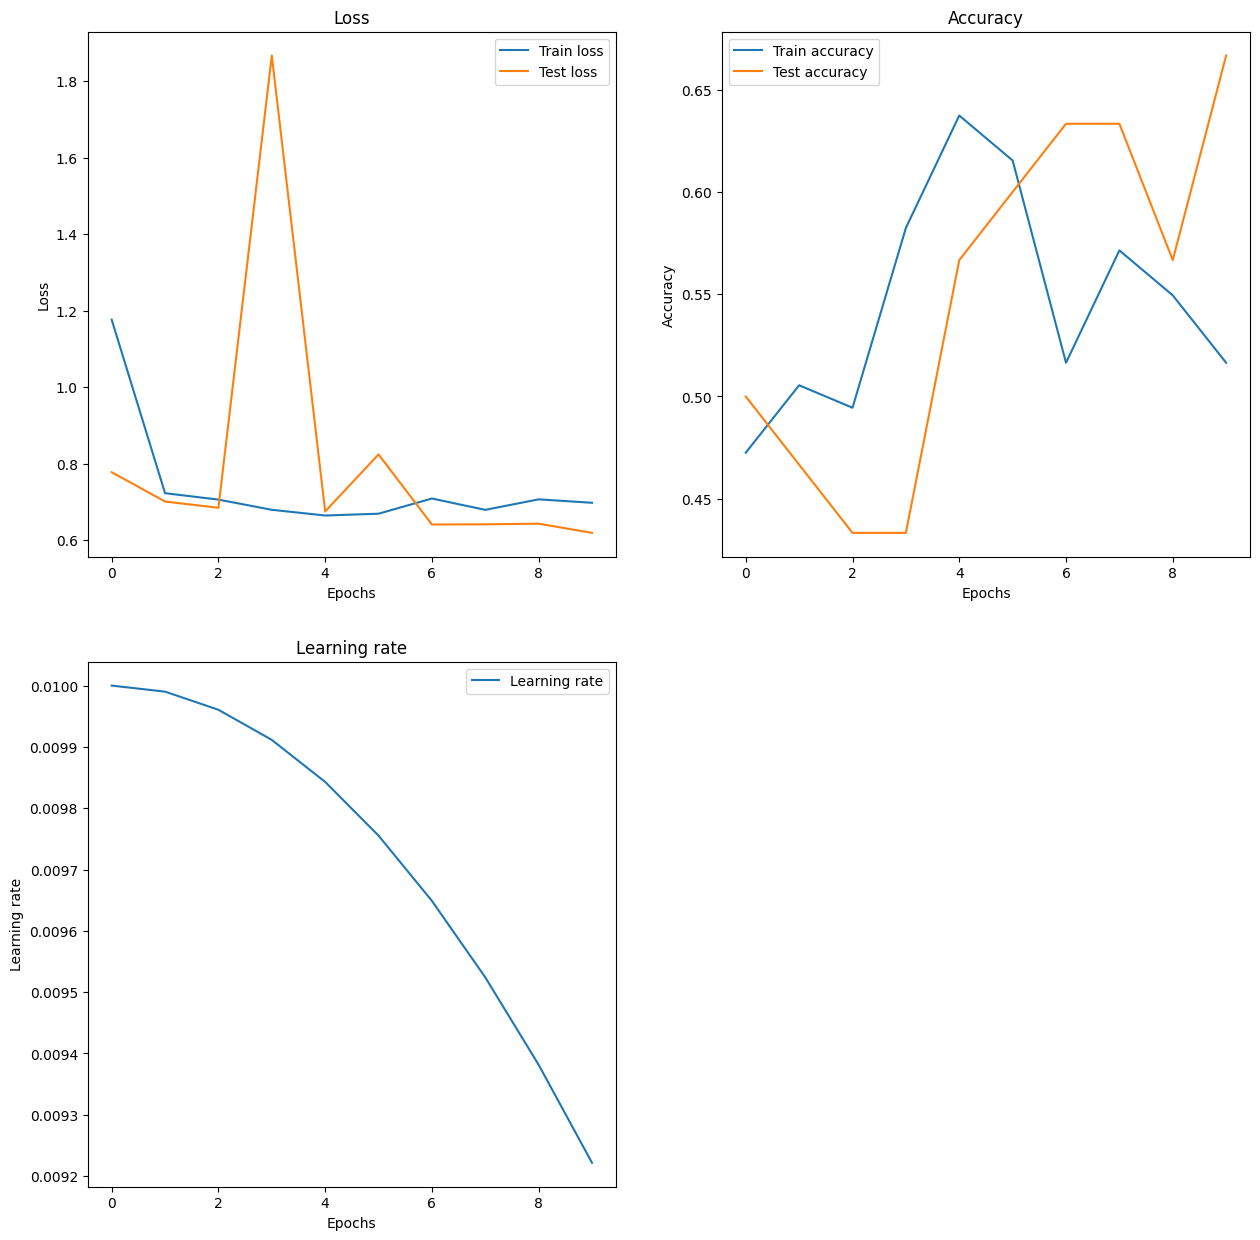

In [13]:
# Train
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt

# Set seed
torch.manual_seed(42)
epochs = 10

# Initialize metrics storage
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []
epoch_count = []
learning_rate = []

# Training loop with tqdm
for epoch in tqdm(range(epochs), desc="Training", total=epochs):
    model.train()

    # Training phase
    running_loss = 0.0
    running_correct = 0
    total = 0

    # Wrap train dataloader with tqdm
    train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for inputs, labels in train_loop:

        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
        inputs = inputs.float()

        optimizer.zero_grad()
        y_preds_probs = model(inputs).squeeze()
        labels = labels.float()
        labels_sameshape_output = labels.squeeze()
        loss = loss_fn(y_preds_probs, labels_sameshape_output)
        loss.backward()
        optimizer.step()



        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        preds = torch.round(y_preds_probs)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)


        # Update progress bar
        train_loop.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{running_correct/total:.4f}'
        })

    # Calculate epoch metrics
    train_loss = running_loss / total
    train_acc = running_correct / total


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # Wrap validation dataloader with tqdm
    val_loop = tqdm(valid_dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
            inputs = inputs.float()

            outputs = model(inputs).squeeze()
            labels = labels.float()
            labels_sameshape_output = labels.squeeze()
            loss = loss_fn(outputs, labels_sameshape_output)
            # Update validation metrics
            val_running_loss += loss.item() * inputs.size(0)
            preds = torch.round(outputs)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # Update progress bar
            val_loop.set_postfix({
                'val_loss': f'{val_running_loss/val_total:.4f}',
                'val_acc': f'{val_correct/val_total:.4f}'
            })

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Store metrics
    current_lr = scheduler.get_last_lr()[0]
    learning_rate.append(current_lr)
    epoch_count.append(epoch)
    train_loss_values.append(train_loss)
    test_loss_values.append(val_loss)
    train_acc_values.append(train_acc)
    test_acc_values.append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{epochs} | "
          f"LR: {current_lr:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Step scheduler
    scheduler.step()

# Plotting
plt.figure(figsize=(15, 15))
# Plot
plt.figure(figsize=(15, 15))
ax_1 = plt.subplot(2, 2, 1)
ax_2 = plt.subplot(2, 2, 2)
ax_3 = plt.subplot(2, 2, 3)
ax_1.plot(epoch_count,
         train_loss_values,
         label="Train loss")
ax_1.plot(epoch_count,
         test_loss_values,
         label="Test loss")
ax_2.plot(epoch_count,
         train_acc_values,
         label="Train accuracy")
ax_2.plot(epoch_count,
         test_acc_values,
         label="Test accuracy")
ax_3.plot(epoch_count,
         learning_rate,
         label="Learning rate")
ax_1.legend()
ax_2.legend()
ax_3.legend()

ax_1.set_xlabel("Epochs")
ax_2.set_xlabel("Epochs")
ax_3.set_xlabel("Epochs")

ax_1.set_ylabel("Loss")
ax_2.set_ylabel("Accuracy")
ax_3.set_ylabel("Learning rate")

ax_1.set_title("Loss")
ax_2.set_title("Accuracy")
ax_3.set_title("Learning rate")
plt.legend();

<Figure size 1500x1500 with 0 Axes>

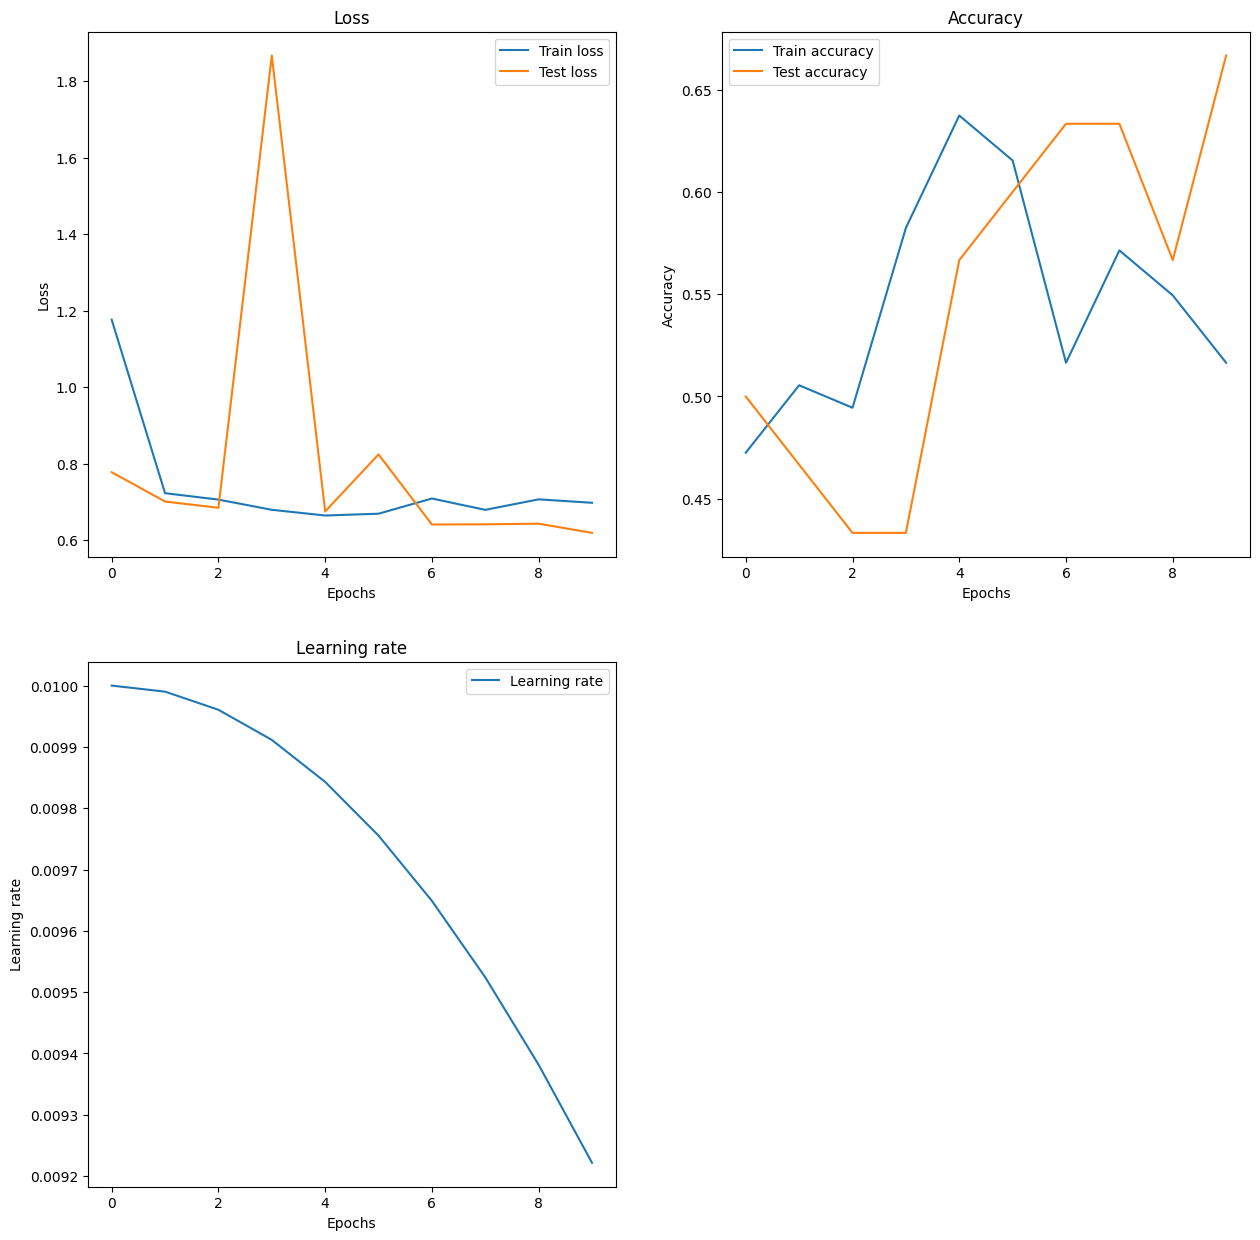

In [17]:
# Plotting
plt.figure(figsize=(15, 15))
# Plot
plt.figure(figsize=(15, 15))
ax_1 = plt.subplot(2, 2, 1)
ax_2 = plt.subplot(2, 2, 2)
ax_3 = plt.subplot(2, 2, 3)
ax_1.plot(epoch_count,
         train_loss_values,
         label="Train loss")
ax_1.plot(epoch_count,
         test_loss_values,
         label="Test loss")
ax_2.plot(epoch_count,
         train_acc_values,
         label="Train accuracy")
ax_2.plot(epoch_count,
         test_acc_values,
         label="Test accuracy")
ax_3.plot(epoch_count,
         learning_rate,
         label="Learning rate")
ax_1.legend()
ax_2.legend()
ax_3.legend()

ax_1.set_xlabel("Epochs")
ax_2.set_xlabel("Epochs")
ax_3.set_xlabel("Epochs")

ax_1.set_ylabel("Loss")
ax_2.set_ylabel("Accuracy")
ax_3.set_ylabel("Learning rate")

ax_1.set_title("Loss")
ax_2.set_title("Accuracy")
ax_3.set_title("Learning rate")
plt.legend();

In [ ]:
# # mIxed precision if model is fp32 and data in fp16
# only use it for gpu constrain not on RAM constraint

# import torch
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from torch.amp import autocast, GradScaler
# import gc

# def train_model_memory_optimized(
#     model,
#     train_dataloader,
#     valid_dataloader,
#     optimizer,
#     scheduler,
#     loss_fn,
#     device,
#     epochs=20,
#     accumulation_steps=4
# ):
# # Initialize metrics and tools
#     metrics = {
#         'train_loss': [], 'train_acc': [],
#         'val_loss': [], 'val_acc': [],
#         'lr': [], 'epoch': []
#     }
#     scaler = GradScaler()
#     torch.manual_seed(42)

#     try:
#       for epoch in range(epochs):
#           # Training Phase
#           model.train()
#           train_loss, train_correct, train_total = 0.0, 0, 0
#           optimizer.zero_grad()
#           # Wrap train dataloader with tqdm
# #         train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
#           with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False) as batch_loop:
#             for batch_idx, (inputs, labels) in enumerate(batch_loop):
#                 # Mini-batch processing with memory optimization
#                 # inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last). # memory_format=torch.channels_last only for 4d tensor. (b, c, h, w)
#                 inputs = inputs.to(device, non_blocking=True)
#                 inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#                 labels = labels.to(device, non_blocking=True)

#                 # Mixed precision forward
#                 with autocast(dtype=torch.float16, device_type=device):
#                     outputs = model(inputs)
#                     loss = loss_fn(outputs, labels) / accumulation_steps

#                 # Scaled backward
#                 scaler.scale(loss).backward()

#                 # Gradient accumulation
#                 if (batch_idx + 1) % accumulation_steps == 0:
#                     #scaler.unscale_(optimizer): Since we are using automatic mixed precision (AMP) with torch.cuda.amp.GradScaler, gradients are initially scaled to prevent underflow.
#                     # Before performing gradient clipping, we unscale them so that clipping operates correctly.
#                     scaler.unscale_(optimizer)
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # This prevents exploding gradients by capping the norm of the gradients to 1.0
#                     scaler.step(optimizer) # This performs the optimizer step, applying the accumulated gradients to update the model weights.
#                     scaler.update() #Updates the GradScaler, which dynamically adjusts the scaling factor to maintain numerical stability.
#                     optimizer.zero_grad(set_to_none=True)  # Reduces memory fragmentation. This allows PyTorch to allocate fresh memory for gradients in the next backward pass, improving performance.
#                 # Update metrics
#                 with torch.no_grad():
#                     train_loss += loss.item() * inputs.size(0) * accumulation_steps
#                     train_correct += (outputs.argmax(1) == labels).sum().item()
#                     train_total += labels.size(0)

#                 # Memory cleanup
#                 del inputs, labels, outputs
#                 torch.cuda.empty_cache()
#                 gc.collect()


#             # Validation Phase
#             model.eval()
#             val_loss, val_correct, val_total = 0.0, 0, 0
#             with torch.no_grad():
#                 for inputs, labels in valid_dataloader:
#                     inputs = inputs.to(device, non_blocking=True)
#                     inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
#                     labels = labels.to(device, non_blocking=True)

#                     with autocast(dtype=torch.float16, device_type=device,):
#                         outputs = model(inputs)
#                         loss = loss_fn(outputs, labels)

#                     val_loss += loss.item() * inputs.size(0)
#                     val_correct += (outputs.argmax(1) == labels).sum().item()
#                     val_total += labels.size(0)

#                     del inputs, labels, outputs
#                     torch.cuda.empty_cache()
#                     gc.collect()

#           # Store metrics
#             lr = scheduler.get_last_lr()[0]
#             metrics['epoch'].append(epoch)
#             metrics['train_loss'].append(train_loss / train_total)
#             metrics['train_acc'].append(train_correct / train_total)
#             metrics['val_loss'].append(val_loss / val_total)
#             metrics['val_acc'].append(val_correct / val_total)
#             metrics['lr'].append(lr)
#             scheduler.step()

#             # Print epoch summary
#             print(f"Epoch {epoch+1}/{epochs} | LR: {lr:.6f}")
#             print(f"Train Loss: {metrics['train_loss'][-1]:.4f} | Acc: {metrics['train_acc'][-1]:.4f}")
#             print(f"Val Loss: {metrics['val_loss'][-1]:.4f} | Acc: {metrics['val_acc'][-1]:.4f}")
#             print(f"GPU Memory: {torch.cuda.max_memory_reserved()/1e9:.2f}GB\n")


#     except RuntimeError as e:
#         if 'out of memory' in str(e):
#             print("\n⚠️ OOM Error! Try:")
#             print("- Reducing batch size")
#             print("- Increasing accumulation steps")
#             print("- Using smaller model")
#         raise



#     # Plotting
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     metrics_list = [
#         ('train_loss', 'val_loss', 'Loss'),
#         ('train_acc', 'val_acc', 'Accuracy'),
#         ('lr', None, 'Learning Rate')
#     ]

#     for i, (train_metric, val_metric, title) in enumerate(metrics_list):
#         axs[i].plot(metrics['epoch'], metrics[train_metric], label=f'Train {title}')
#         if val_metric:
#             axs[i].plot(metrics['epoch'], metrics[val_metric], label=f'Val {title}')
#         axs[i].set_xlabel('Epochs')
#         axs[i].set_ylabel(title)
#         axs[i].legend()
#         axs[i].set_title(title)

#     plt.tight_layout()
#     return metrics

In [22]:
import psutil
print(f"RAM Usage: {psutil.Process().memory_info().rss / 1e9:.2f}GB")

RAM Usage: 2.43GB


In [ ]:
# # Run training
# metrics = train_model_memory_optimized(
#     model=model,
#     train_dataloader=train_dataloader,
#     valid_dataloader=valid_dataloader,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     loss_fn=loss_fn,
#     device=device,
#     epochs=5,
#     accumulation_steps=4
# )

In [ ]:
# To restart runtime
import os
os.kill(os.getpid(), 9)

# Confusion matrix

In [14]:
# Note: the confusion matrix code we're about to write is a remix of scikit-learn's plot_confusion_matrix
# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confusion matrix
  cm = confusion_matrix(y_true,y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] #normalize our confusion matrix

  n_classes = cm.shape[0]

  # Let's prettify it


  fig, ax = plt.subplots(figsize = figsize)

  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


# Set labels to the classes
  if classes is not None:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])  # setting labels 0 t0 1, as shape[0] is 2

  # Labels the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel = "True label",
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
        )

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Rotate x-axis labels
  plt.xticks(rotation=45)

  # Adjust the labels size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for direction colors
  threshold = (cm.max() + cm.min()) /2.  # give different shades of color respective to how many values are in each box , darker for more value

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size
            )
  plt.tight_layout()

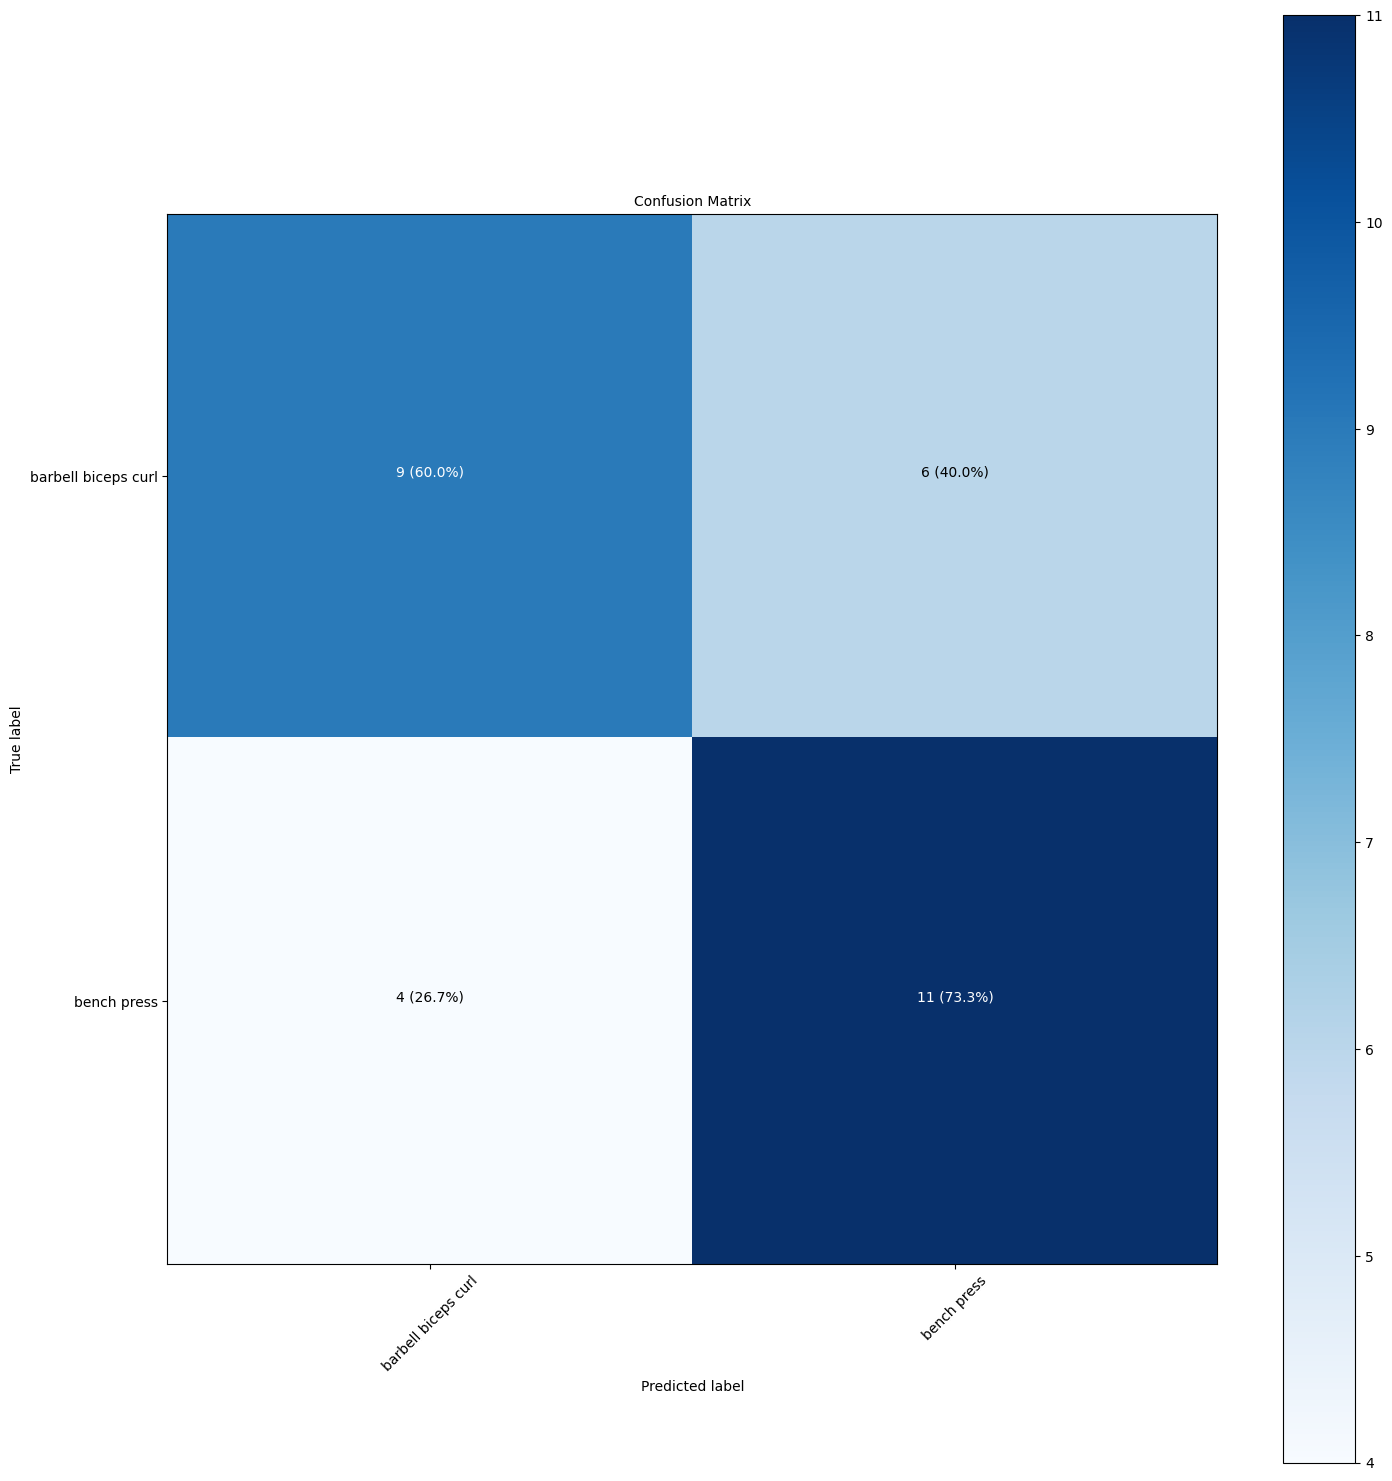

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Validation phase
model.eval()
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        inputs = inputs/255.0 # changing to float32 here. bad practice but RAM issue. no choice
        inputs = inputs.float()

        outputs = model(inputs).squeeze()
        labels = labels.float()
        preds = torch.round(outputs)
        # Append predictions and labels to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
make_confusion_matrix(all_labels,all_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10
                      )